# HEOM 1d: Spin-Bath model, fitting of spectrum and correlation functions

## Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded 
in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single bosonic environment.

The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The bosonic environment is implicitly assumed to obey a particular Hamiltonian ([see paper](https://arxiv.org/abs/2010.10806)), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model an Ohmic environment with exponential cut-off in three ways:

* First we fit the spectral density with a set of underdamped brownian oscillator functions.
* Second, we evaluate the correlation functions, and fit those with a certain choice of exponential functions.
* Third, we use the built-in OhmicBath class, and explore the other approximation methods QuTiP offers

In each case we will use the fit parameters to determine the correlation function expansion co-efficients needed to construct a description of the bath (i.e. a `BosonicEnvironment` object) to supply to the `HEOMSolver` so that we can solve for the system dynamics.

## Setup

In [1]:
# mpmath is required for this tutorial,
# for the evaluation of gamma and zeta
# functions in the expression for the correlation:
from mpmath import mp

import numpy as np
from matplotlib import pyplot as plt

from qutip import about, basis, expect, sigmax, sigmaz
from qutip.core.environment import BosonicEnvironment, OhmicEnvironment
from qutip.solver.heom import HEOMSolver

%matplotlib inline

mp.dps = 15
mp.pretty = True

## System and bath definition

Let us set up the system Hamiltonian, bath and system measurement operators:

### System Hamiltonian

In [2]:
# Defining the system Hamiltonian
eps = 0    # Energy of the 2-level system.
Del = 0.2  # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()

# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()

### System measurement operators

In [3]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

### Analytical expressions for the Ohmic bath correlation function and spectral density

Before we begin fitting, let us examine the analytic expressions for the correlation and spectral density functions and write Python equivalents. 

The correlation function is given by (see, e.g., http://www1.itp.tu-berlin.de/brandes/public_html/publications/notes.pdf for a derivation, equation 7.59, but with a factor of $\pi$ moved into the definition of the correlation function):

\begin{align}
C(t) =& \: \frac{1}{\pi}\alpha \omega_{c}^{1 - s} \beta^{- (s + 1)} \: \times \\
      & \: \Gamma(s + 1) \left[ \zeta \left(s + 1, \frac{1 + \beta \omega_c - i \omega_c t}{\beta \omega_c}\right) + \zeta \left(s + 1, \frac{1 + i \omega_c t}{\beta \omega_c}\right) \right]
\end{align}

where $\Gamma$ is the Gamma function and

\begin{equation}
\zeta(z, u) \equiv \sum_{n=0}^{\infty} \frac{1}{(n + u)^z}, \; u \neq 0, -1, -2, \ldots
\end{equation}

is the generalized Zeta function. The Ohmic case is given by $s = 1$.

The corresponding spectral density for the Ohmic case is:

\begin{equation}
J(\omega) = \omega \alpha e^{- \frac{\omega}{\omega_c}}
\end{equation}

In [4]:
def ohmic_correlation(t, alpha, wc, beta, s=1):
    """ The Ohmic bath correlation function as a function of t
        (and the bath parameters).
    """
    corr = (1 / np.pi) * alpha * wc ** (1 - s)
    corr *= beta ** (-(s + 1)) * mp.gamma(s + 1)
    z1_u = (1 + beta * wc - 1.0j * wc * t) / (beta * wc)
    z2_u = (1 + 1.0j * wc * t) / (beta * wc)
    # Note: the arguments to zeta should be in as high precision as possible.
    # See http://mpmath.org/doc/current/basics.html#providing-correct-input
    return np.array(
        [
            complex(corr * (mp.zeta(s + 1, u1) + mp.zeta(s + 1, u2)))
            for u1, u2 in zip(z1_u, z2_u)
        ],
        dtype=np.complex128,
    )

In [5]:
def ohmic_spectral_density(w, alpha, wc):
    """ The Ohmic bath spectral density as a function of w
        (and the bath parameters).
    """
    return w * alpha * np.e ** (-w / wc)

In [6]:
def ohmic_power_spectrum(w, alpha, wc, beta):
    """ The Ohmic bath power spectrum as a function of w
        (and the bath parameters).
        We here obtain it naively using the Fluctuation-Dissipation Theorem,
        but this fails at w=0 where the limit should be taken properly
    """
    bose = (1 / (np.e ** (w * beta) - 1)) + 1
    return w * alpha * np.e ** (-abs(w) / wc) * 2 * bose

### Bath and HEOM parameters

Finally, let's set the bath parameters we will work with

In [7]:
Q = sigmaz()
alpha = 3.25
T = 0.5
wc = 1.0
s = 1

and set the cut-off for the HEOM hierarchy:

In [8]:
# HEOM parameters:

# The max_depth defaults to 5 so that the notebook executes more
# quickly. Change it to 11 to wait longer for more accurate results.
max_depth = 5

# options used for the differential equation solver
# "bdf" integration method is faster here
options = {
    "nsteps": 15000,
    "store_states": True,
    "rtol": 1e-12,
    "atol": 1e-12,
    "method": "bdf",
}

# Obtaining a decaying Exponential description of the environment

In order to carry out our HEOM simulation, we need to express the correlation 
function as a sum of decaying exponentials, that is we need to express it as 

$$C(\tau)= \sum_{k=0}^{N-1}c_{k}e^{-\nu_{k}t}$$

As the correlation function of the environment is tied to it's power spectrum via 
a Fourier transform, such a representation of the correlation function implies a 
power spectrum of the form

$$S(\omega)= \sum_{k}2 Re\left( \frac{c_{k}}{\nu_{k}- i \omega}\right)$$

There are several ways one can obtain such a decomposition, in this tutorial we 
will cover the following approaches:

- Non-Linear Least Squares:
    - On the Spectral Density (`sd`)
    - On the Correlation function (`cf`)
    - On the Power spectrum (`ps`)
- Methods based on the Prony Polynomial
    - Prony on the correlation function(`prony`)
    - ESPRIT on the correlation function(`esprit`)
- Methods based on rational Approximations
    - The AAA algorithm on the Power Spectrum (`aaa`)
    - ESPIRA-I on the correlation function and its FFT (`espira-I`)
    - ESPIRA-II on the correlation function and its FFT (`espira-II`)

## Building User defined Bosonic Environments

Before obtaining exponential approximations, we first need to construct a 
`BosonicEnviroment` describing the exact environment.
Here, we will briefly explain how to create a user-defined 
`BosonicEnviroment` by specifying the spectral density. The same can be done 
using either the correlation function or the power spectrum. For this example, we will
use the Ohmic Spectral density we defined above:

In [9]:
w = np.linspace(0, 25, 20000)
J = ohmic_spectral_density(w, alpha, wc)

The `BosonicEnvironment` class has special constructors that can be used to 
create environments from arbitrary spectral densities, correlation functions, or
power spectrums. For example:

In [10]:
# From an array
sd_env = BosonicEnvironment.from_spectral_density(J=J, wlist=w, T=T)

Specifying the temperature is optional, but it allows us to automatically compute the corresponding power spectrum and correlation function. For example, the automatically computed power spectrum matches the analytically defined `ohmic_power_spectrum` function from above:

In [11]:
# Here we avoid w=0
np.allclose(
    sd_env.power_spectrum(w[1:]), ohmic_power_spectrum(w[1:], alpha, wc, 1 / T)
)

True

Specifying the Temperature also allows QuTiP to automatically compute the correlation function by fast Fourier transformation:

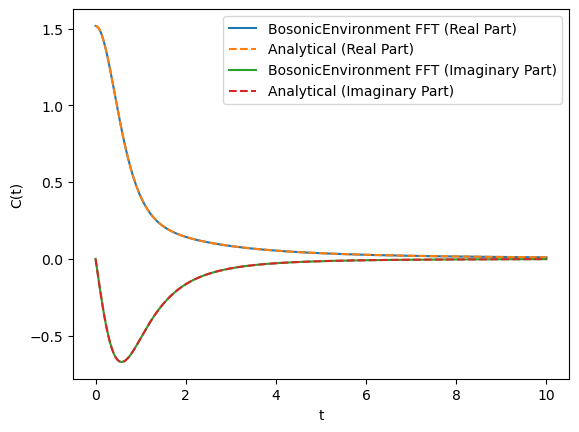

In [12]:
tlist = np.linspace(0, 10, 500)
plt.plot(
    tlist,
    sd_env.correlation_function(tlist).real,
    label="BosonicEnvironment FFT (Real Part)",
)
plt.plot(
    tlist,
    ohmic_correlation(tlist, alpha, wc, 1 / T).real,
    "--",
    label="Analytical (Real Part)",
)
plt.plot(
    tlist,
    np.imag(sd_env.correlation_function(tlist)),
    label="BosonicEnvironment FFT (Imaginary Part)",
)
plt.plot(
    tlist,
    np.imag(ohmic_correlation(tlist, alpha, wc, 1 / T)),
    "--",
    label="Analytical (Imaginary Part)",
)
plt.ylabel("C(t)")
plt.xlabel("t")
plt.legend()
plt.show()

Note that above, we constructed the `BosonicEnvironment` from the arrays `w` and `J`.
Instead, one can also use a pure Python function.
In that case, it is important to specify the parameter `wMax`, which is the cutoff frequency where the 
spectral density or power spectrum has effectively decayed to zero. That is, for $\omega > \omega_{max}$, the function can be 
considered to be essentially zero. The following is therefore equivalent to the environment that we used above:

In [13]:
# From a function
sd_env2 = BosonicEnvironment.from_spectral_density(
    ohmic_spectral_density, T=T, wMax=25 * wc, args={"alpha": alpha, "wc": wc}
)

## Building the Exponential environment by fitting the spectral density

Once our `BosonicEnvironment` has been constructed, we can obtain a decaying
exponential representation of the environment, via fitting either the spectral
density, power spectrum or the correlation function. 

We begin with a nonlinear-least-squares fit of the spectral density, using a series of $k$ underdamped harmonic oscillators case with the Meier-Tannor form (J. Chem. Phys. 111, 3365 (1999); https://doi.org/10.1063/1.479669):

\begin{equation}
J_{\mathrm approx}(\omega; a, b, c) = \sum_{i=0}^{k-1} \frac{2 a_i b_i w}{((w + c_i)^2 + b_i^2) ((w - c_i)^2 + b_i^2)}
\end{equation}

where $a, b$ and $c$ are the fit parameters and each is a vector of length $k$.
The idea here is that we express our arbitrary spectral density as a sum of 
underdamped spectral densities with different coefficients, for which the
Matsubara decomposition is available.

The fit can be done easily using the `approximate` method. Its output is a tuple containing an `ExponentialBosonicEnvironment`
and a dictionary that has all the relevant information about the fit performed.
The goodness of the fit is measured via the normalized root mean squared error.

By default, the number of terms in the fit is increased automatically until the target accuracy 
is reached or the maximum number allowed terms `Nmax` is reached. (The target accuracy can be set to None,
then the fit is performed only with the specified number `Nmax` of exponents.)

In [14]:
# adding a small uncertainty "sigma" helps the fit routine
approx_env, fitinfo = sd_env.approximate("sd", w, Nmax=4, sigma=0.0001)

To obtain an overview of the results of the fit we may take a look at the summary from the ``fitinfo``

In [15]:
print(fitinfo["summary"])

Result of fitting the spectral density with 4 terms: 
 
 Parameters|    a     |    b     |    c 
 1         | 7.92e+00 | 2.30e+00 |1.00e-01
 2         | 6.01e-01 | 1.00e+00 |1.00e-01
 3         |-4.41e+00 | 4.30e+00 |3.98e+00
 4         | 1.06e-02 | 3.07e-01 |1.00e-01
 
A RMSE of  2.93e-04 was obtained for the the spectral density.
The current fit took  1.824297 seconds.


Since the effective spectral density and power spectrum corresponding to the approximated correlation function are available through the `approx_env` object, we can compare them to the original:

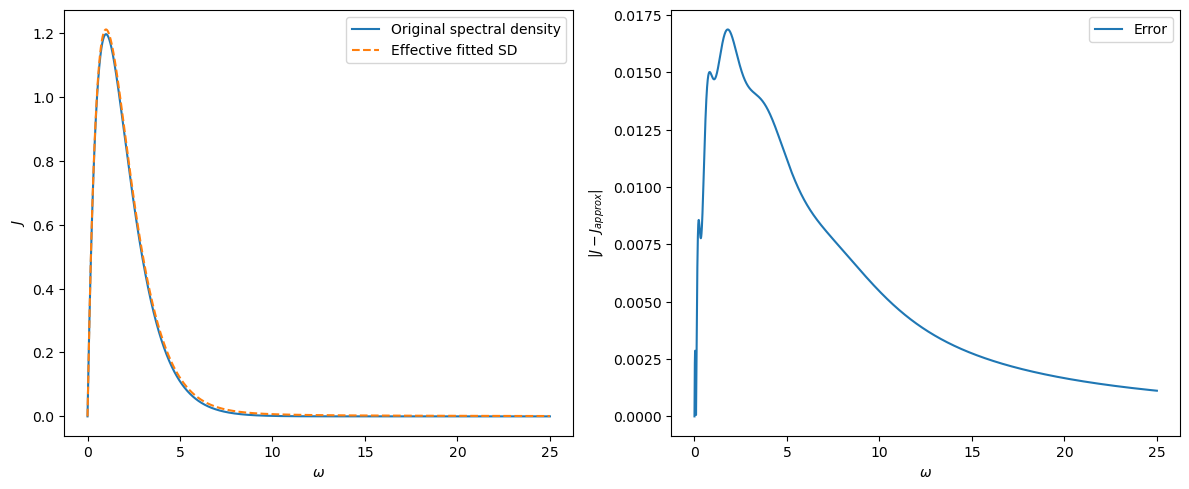

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.plot(w, J, label="Original spectral density")
ax1.plot(w, approx_env.spectral_density(w), "--", label="Effective fitted SD")
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$J$")
ax1.legend()

ax2.plot(w, np.abs(J - approx_env.spectral_density(w)), label="Error")
ax2.set_xlabel(r"$\omega$")
ax2.set_ylabel(r"$|J-J_{approx}|$")
ax2.legend()

fig.tight_layout()
plt.show()

Here we see a surprisingly large discrepancy in our approximated or effective spectral density. This happens because we are not using enough exponentials (i.e., not enough Matsubara terms) from each of the underdamped modes to have an appropiate fit. All modes use the same number of Matsubara terms; when not specified, the number defaults to $1$, which is not enough to model a bath with the temperature considered here. Let us repeat this with a larger number of exponents.

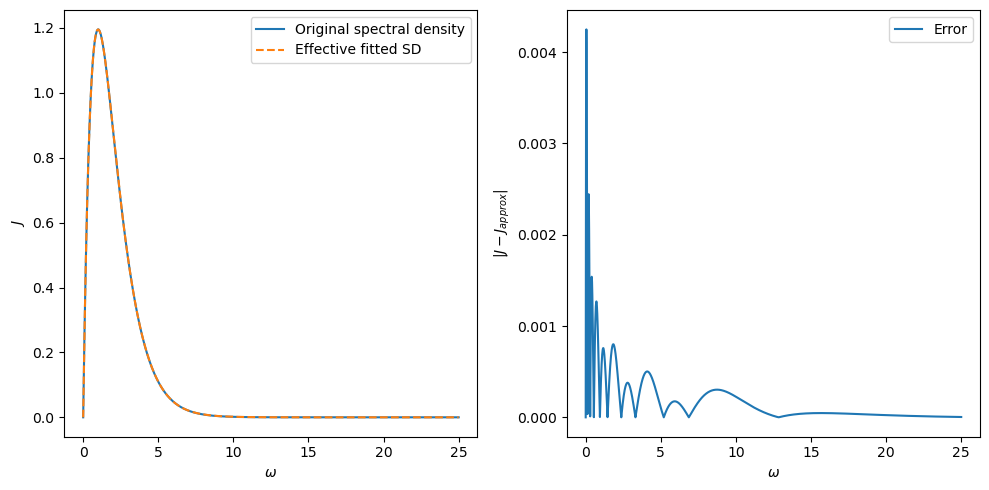

In [17]:
# 3 Matsubara terms per mode instead of one (default)
approx_env, fitinfo = sd_env.approximate("sd", w, Nmax=4, Nk=3, sigma=0.0001)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.plot(w, J, label="Original spectral density")
ax1.plot(w, approx_env.spectral_density(w), "--", label="Effective fitted SD")
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$J$")
ax1.legend()

ax2.plot(w, np.abs(J - approx_env.spectral_density(w)), label="Error")
ax2.set_xlabel(r"$\omega$")
ax2.set_ylabel(r"$|J-J_{approx}|$")
ax2.legend()

fig.tight_layout()
plt.show()

Since the number of exponents increases simulation time, one should go with the least amount of exponents that correctly describe the bath properties (Power spectrum, Spectral density and the correlation function).

Let's take a closer look at our last fit by plotting the contribution of each term of the fit:

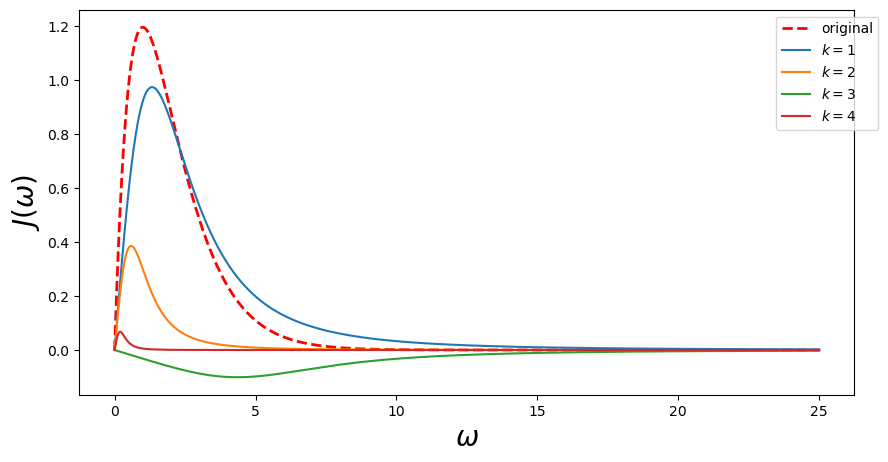

In [18]:
def plot_fit_components(func, J, w, lam, gamma, w0):
    """ Plot the individual components of a fit to the spectral density
        and how they contribute to the full fit"""
    plt.figure(figsize=(10, 5))
    plt.plot(w, J, "r--", linewidth=2, label="original")
    for i in range(len(lam)):
        component = func(w, lam[i], gamma[i], w0[i])
        plt.plot(w, component, label=rf"$k={i+1}$")
    plt.xlabel(r"$\omega$", fontsize=20)
    plt.ylabel(r"$J(\omega)$", fontsize=20)
    plt.legend(bbox_to_anchor=(1.04, 1))
    plt.show()

lam = fitinfo["params"][:, 0]
gamma = fitinfo["params"][:, 1]
w0 = fitinfo["params"][:, 2]

def _sd_fit_model(wlist, a, b, c):
    return (
        2 * a * b * wlist
        / (((wlist + c) ** 2 + b**2) * ((wlist - c) ** 2 + b**2))
    )

plot_fit_components(_sd_fit_model, J, w, lam, gamma, w0)

And let's also compare the power spectrum of the fit and the analytical spectral density:

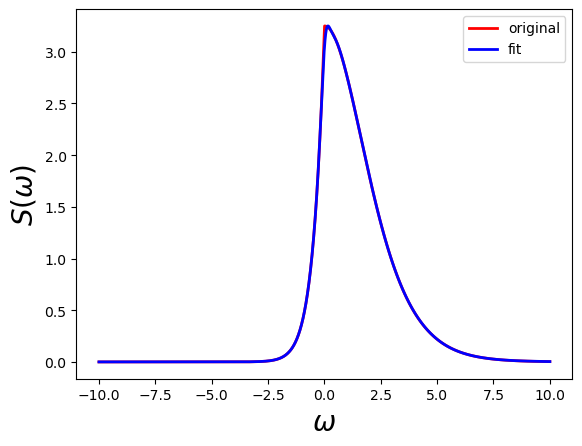

In [19]:
def plot_power_spectrum(alpha, wc, beta):
    """ Plot the power spectrum of a fit against the actual power spectrum. """
    w = np.linspace(-10, 10, 50000)
    s_orig = ohmic_power_spectrum(w, alpha=alpha, wc=wc, beta=beta)
    s_fit = approx_env.power_spectrum(w)
    fig, axes = plt.subplots(1, 1, sharex=True)
    axes.plot(w, s_orig, "r", linewidth=2, label="original")
    axes.plot(w, np.real(s_fit), "b", linewidth=2, label="fit")

    axes.set_xlabel(r"$\omega$", fontsize=20)
    axes.set_ylabel(r"$S(\omega)$", fontsize=20)
    axes.legend()

plot_power_spectrum(alpha, wc, 1 / T)

Now if we want to see the systems's behaviour as we change the parameters of the fit and the simulation, we may use this auxiliary function.

In [20]:
def generate_spectrum_results(N, Nk, max_depth):
    """ Run the HEOM with the given bath parameters and
        and return the results of the evolution.
    """
    approx_env, fitinfo = sd_env.approximate(
        "sd", w, Nmax=N, Nk=Nk, sigma=0.0001, target_rmse=None
    )
    tlist = np.linspace(0, 30 * np.pi / Del, 600)

    print(f"Starting calculations for N={N}, Nk={Nk}"
          f" and max_depth={max_depth} ... ")

    HEOM_spectral_fit = HEOMSolver(
        Hsys, (approx_env, Q), max_depth=max_depth,
        options={**options, 'progress_bar': False},
    )
    results_spectral_fit = HEOM_spectral_fit.run(rho0, tlist)
    return results_spectral_fit

In [21]:
def plot_result_expectations(plots, axes=None):
    """ Plot the expectation values of operators as functions of time.

        Each plot in plots consists of (solver_result,
        measurement_operation, color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True)
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        if color == "rand":
            axes.plot(result.times, exp, color=np.random.rand(3),
                      label=label, **kw)
        else:
            axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=20)

    return fig

Below we generate results for different convergence parameters (number of terms in the fit, number of matsubara terms, and depth of the hierarchy).  For the parameter choices here, we need a relatively large depth of around '11', which can be a little slow.

Starting calculations for N=1, Nk=1 and max_depth=5 ... 


Starting calculations for N=2, Nk=1 and max_depth=5 ... 


Starting calculations for N=3, Nk=1 and max_depth=5 ... 


Starting calculations for N=4, Nk=1 and max_depth=5 ... 


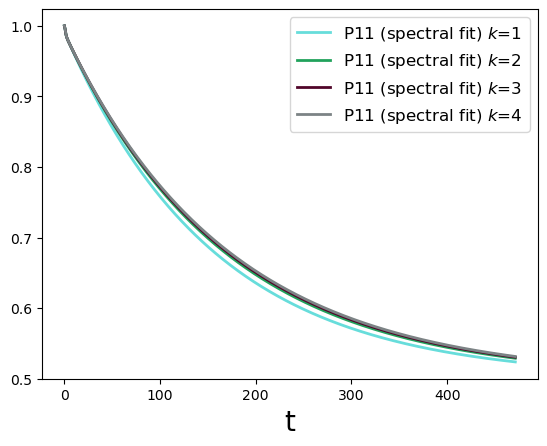

In [22]:
# Generate results for different number of lorentzians in fit:

results_spectral_fit_pk = [
    generate_spectrum_results(n, Nk=1, max_depth=max_depth)
    for n in range(1, 5)
]

plot_result_expectations([
    (result, P11p, "rand", f"P11 (spectral fit) $k$={pk + 1}")
    for pk, result in enumerate(results_spectral_fit_pk)
]);

Starting calculations for N=4, Nk=1 and max_depth=5 ... 


Starting calculations for N=4, Nk=2 and max_depth=5 ... 


Starting calculations for N=4, Nk=3 and max_depth=5 ... 


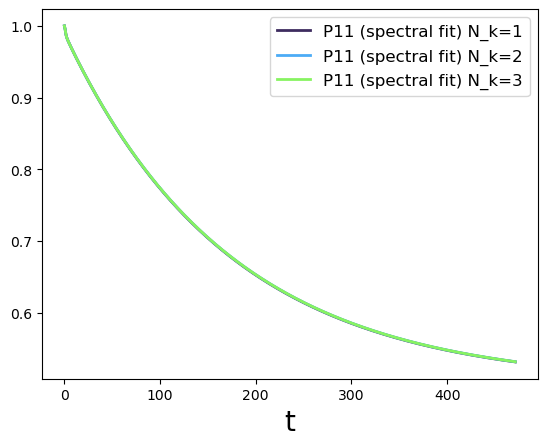

In [23]:
# generate results for different number of Matsubara terms per Lorentzian:

Nk_list = range(1, 4)
results_spectral_fit_nk = [
    generate_spectrum_results(4, Nk=Nk, max_depth=max_depth)
    for Nk in Nk_list
]

plot_result_expectations([
    (result, P11p, "rand", f"P11 (spectral fit) N_k={nk}")
    for nk, result in zip(Nk_list, results_spectral_fit_nk)
]);

Starting calculations for N=4, Nk=1 and max_depth=3 ... 


Starting calculations for N=4, Nk=1 and max_depth=4 ... 


Starting calculations for N=4, Nk=1 and max_depth=5 ... 


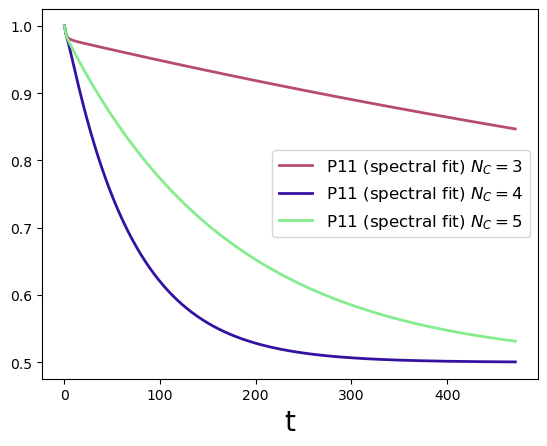

In [24]:
# generate results for different hierarchy depths:

Nc_list = range(3, max_depth+1)
results_spectral_fit_nc = [
    generate_spectrum_results(4, Nk=1, max_depth=Nc)
    for Nc in Nc_list
]

plot_result_expectations([
    (result, P11p, "rand", f"P11 (spectral fit) $N_C={nc}$")
    for nc, result in zip(Nc_list, results_spectral_fit_nc)
]);

## Obtaining a decaying exponential description by fitting the correlation function

Having successfully fitted the spectral density and used the result to calculate the Matsubara expansion and terminator for the HEOM bosonic bath, we now proceed to the second case of fitting the correlation function itself instead.

Here we fit the real and imaginary parts separately, using the following ansatz 

$$C_R^F(t) = \sum_{i=1}^{k_R} c_R^ie^{-\gamma_R^i t}\cos(\omega_R^i t)$$

$$C_I^F(t) = \sum_{i=1}^{k_I} c_I^ie^{-\gamma_I^i t}\sin(\omega_I^i t)$$

Also this fit can easily be performed using the `approximate` method. The main difference with respect to the spectral density fit is that now we are perfoming two fits, one for the real part and another one for the imaginary part.

Note that the ansatz is not good if $C_I^F(0) \neq 0$. In this case, the option `full_ansatz=True` allows for the usage of a 
more general ansatz. The fit however tends to be significantly slower. We refer to the documentation for details.

In [25]:
def generate_corr_results(N, max_depth):
    tlist = np.linspace(0, 30 * np.pi / Del, 600)
    approx_env, fitinfo = sd_env.approximate(
        "cf", tlist=tlist, Ni_max=N, Nr_max=N, maxfev=1e8, target_rmse=None
    )

    print(f"Starting calculations for N={N}"
          f" and max_depth={max_depth} ... ")

    HEOM_corr_fit = HEOMSolver(
        Hsys, (approx_env, Q), max_depth=max_depth,
        options={**options, 'progress_bar': False},
    )
    results_corr_fit = HEOM_corr_fit.run(rho0, tlist)
    return results_corr_fit

Starting calculations for N=1 and max_depth=5 ... 


Starting calculations for N=2 and max_depth=5 ... 


Starting calculations for N=3 and max_depth=5 ... 


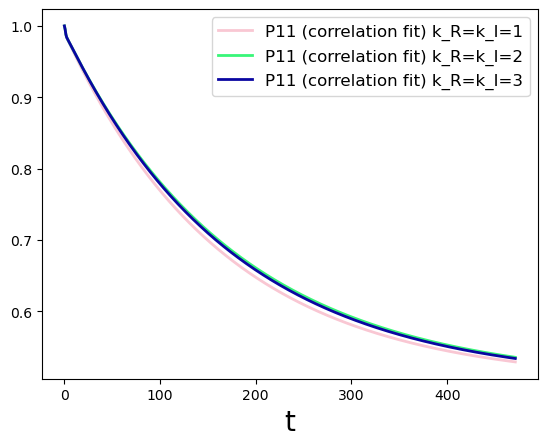

In [26]:
# Generate results for different number of exponentials in fit:
results_corr_fit_pk = [
    generate_corr_results(i, max_depth=max_depth)
    for i in range(1, 4)
]

plot_result_expectations([
    (result, P11p, "rand", f"P11 (correlation fit) k_R=k_I={pk + 1}")
    for pk, result in enumerate(results_corr_fit_pk)
]);

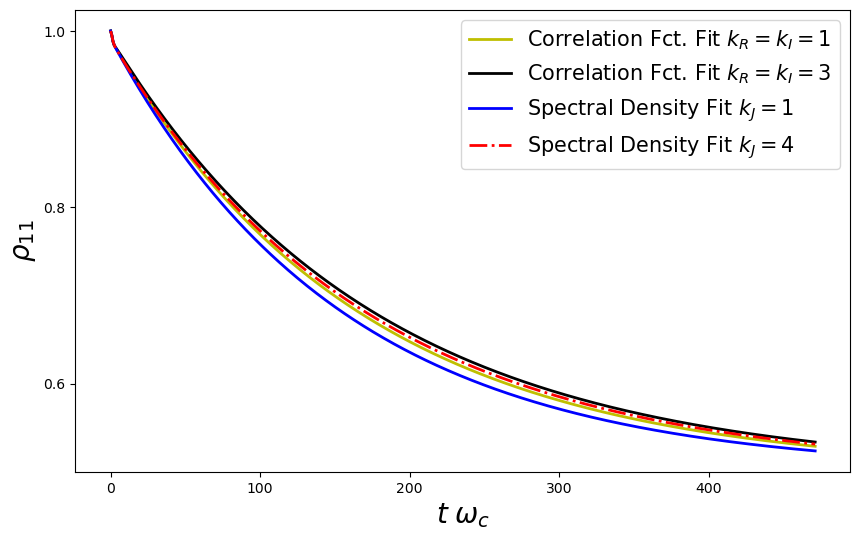

In [27]:
# Comparison plot

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

plot_result_expectations([
    (results_corr_fit_pk[0], P11p, "y", "Correlation Fct. Fit $k_R=k_I=1$"),
    (results_corr_fit_pk[2], P11p, "k", "Correlation Fct. Fit $k_R=k_I=3$"),
    (results_spectral_fit_pk[0], P11p, "b", "Spectral Density Fit $k_J=1$"),
    (results_spectral_fit_pk[3], P11p, "r-.", "Spectral Density Fit $k_J=4$"),
], axes=axes)

axes.set_yticks([0.6, 0.8, 1])
axes.set_ylabel(r"$\rho_{11}$", fontsize=20)
axes.set_xlabel(r"$t\;\omega_c$", fontsize=20)
axes.legend(loc=0, fontsize=15);

# Using the Ohmic Environment class

As the ohmic spectrum is popular in the modeling of open quantum systems, it has its own dedicated class. The results above can be reproduced quickly by using the `OhmicEnvironment` class. This allows for rapid implementation of fitted Ohmic baths.

In [28]:
obs = OhmicEnvironment(T, alpha, wc, s=1)
tlist = np.linspace(0, 30 * np.pi / Del, 600)

Just like the other `BosonicEnvironment` we can obtain a decaying exponential 
representation of the environment via the `approximate` function. Let us first do the same 
methods we explored before:

In [29]:
sd_approx_env, fitinfo = obs.approximate(
    method="sd", wlist=w, Nmax=4, Nk=3, sigma=0.0001, target_rmse=None
)
print(fitinfo["summary"])
HEOM_ohmic_sd_fit = HEOMSolver(
    Hsys, (sd_approx_env, Q), max_depth=max_depth, options=options
)
results_ohmic_sd_fit = HEOM_ohmic_sd_fit.run(rho0, tlist)

Result of fitting the spectral density with 4 terms: 
 
 Parameters|    a     |    b     |    c 
 1         | 7.92e+00 | 2.30e+00 |1.00e-01
 2         | 6.01e-01 | 1.00e+00 |1.00e-01
 3         |-4.41e+00 | 4.30e+00 |3.98e+00
 4         | 1.06e-02 | 3.07e-01 |1.00e-01
 
A RMSE of  2.93e-04 was obtained for the the spectral density.
The current fit took  1.128710 seconds.


10.0%. Run time:   4.88s. Est. time left: 00:00:00:43


20.0%. Run time:   8.09s. Est. time left: 00:00:00:32


30.1%. Run time:  11.36s. Est. time left: 00:00:00:26


40.1%. Run time:  14.68s. Est. time left: 00:00:00:21


50.1%. Run time:  18.14s. Est. time left: 00:00:00:18


60.1%. Run time:  21.50s. Est. time left: 00:00:00:14


70.1%. Run time:  25.18s. Est. time left: 00:00:00:10


80.1%. Run time:  29.31s. Est. time left: 00:00:00:07


90.2%. Run time:  33.40s. Est. time left: 00:00:00:03


100.0%. Run time:  37.86s. Est. time left: 00:00:00:00


Total run time:  37.86s


In [30]:
cf_approx_env, fitinfo = obs.approximate(
    method="cf", tlist=tlist, Nr_max=4, Ni_max=4, maxfev=1e8, target_rmse=None
)
print(fitinfo["summary"])
HEOM_ohmic_corr_fit = HEOMSolver(
    Hsys, (cf_approx_env, Q), max_depth=max_depth, options=options
)
results_ohmic_corr_fit = HEOM_ohmic_corr_fit.run(rho0, tlist)

Correlation function fit:

Result of fitting the real part of                        |Result of fitting the imaginary part                       
the correlation function with 4 terms:                    |of the correlation function with 4 terms:                  
                                                          |                                                           
 Parameters|   ckr    |   vkr    |  vki                   | Parameters|   ckr    |   vkr    |  vki                    
 1         |-2.67e-01 |-1.62e+00 |4.66e+00                | 1         |-3.44e+00 |-1.69e-01 |1.09e-04                 
 2         | 2.53e-01 |-4.52e-01 |8.75e-29                | 2         |-9.20e+00 |-2.34e+00 |4.10e-01                 
 3         | 1.51e+00 |-1.96e+00 |1.94e-24                | 3         |-9.88e+00 |-5.11e-01 |2.19e-03                 
 4         | 1.71e-02 |-9.03e-02 |1.25e-30                | 4         |-1.24e+01 |-1.20e+00 |3.85e-02                 
                     

10.0%. Run time:   8.08s. Est. time left: 00:00:01:12


20.0%. Run time:  14.23s. Est. time left: 00:00:00:56


30.1%. Run time:  20.36s. Est. time left: 00:00:00:47


40.1%. Run time:  26.49s. Est. time left: 00:00:00:39


50.1%. Run time:  32.62s. Est. time left: 00:00:00:32


60.1%. Run time:  38.71s. Est. time left: 00:00:00:25


70.1%. Run time:  44.78s. Est. time left: 00:00:00:19


80.1%. Run time:  50.83s. Est. time left: 00:00:00:12


90.2%. Run time:  56.85s. Est. time left: 00:00:00:06


100.0%. Run time:  62.75s. Est. time left: 00:00:00:00


Total run time:  62.75s


## Other Approximation methods
### Methods based on the Prony Polynomial 

The Prony polynomial forms the mathematical foundation for many spectral analysis techniques that estimate frequencies, damping factors, and amplitudes of signals. These methods work by interpreting a given signal as a sum of complex exponentials and deriving a polynomial whose roots correspond to the frequencies or poles of the system.

The methods consider a signal 

$$f(t)=\sum_{k=0}^{N-1} c_{k} e^{-\nu_{k} t} =\sum_{k=0}^{N-1} c_{k} z_{k}^{t}  $$

The $z_{k}$ can be seen as the generalized eigenvalues of the matrix pencil

\begin{align}
z_{j}  {\mathbf H}_{2N-L,L}(0) - {\mathbf H}_{2N-L,L}(1) = {\mathbf V}_{2N-L,M}
({\mathbf z})   \mathrm{diag}  \Big( \left( (z_{j} - z_{k})\gamma_{k} 
\right)_{k=1}^{M} \Big) {\mathbf V}_{L,M}({\mathbf z})^{T}
\end{align}



The amplitudes ($c_{k}$) can later be obtained by solving the least-squares Vandermonde system given by

$$ V_{N,M}(z)c = f $$

where $V_{N,M}(z)$ is the Vandermonde matrix given by


$$V_{M,N}(z)=\begin{pmatrix} 
1 &1 &\dots &1 \\
z_{1} & z_{2} &\dots & z_{N} \\
z_{1}^{2} & z_{2}^{2} &\dots & z_{N}^{2} \\
\vdots & \vdots & \ddots & \vdots  \\
z_{1}^{M} & z_{2}^{M} &\dots & z_{N}^{M} \\
\end{pmatrix}$$

and $M$ is the length of the signal, and $N$ the number of exponents, and $f=f(t_{sample})$ is the signal evaluated in the sampling points,is a vector $c = (c_{1}, \dots, c_{N})$.

The main difference between the methods is the way one obtains the roots of the polynomial, typically whether this system is solved or a low rank approximation is found for the polynomial. [This article](https://academic.oup.com/imajna/article-abstract/43/2/789/6525860?redirectedFrom=fulltext) is a good reference, the QuTiP implementations are based on it and on the matlab implementations made available by the authors.

The prony like methods include:

- Prony
- ESPRIT
- ESPIRA

Though ESPIRA is prony like, since it is based on rational polynomial approximations
we group it with other methods.

##### Using the Original Prony Method on the Correlation Function

The method is available via `approximate` passing "prony" as method. Compared to the other approaches showed so far. The Prony based methods, shine on their simplicity no information needs to be known about the function, and one just needs to provide the sampling points, and the Number of Exponents one desires

In [31]:
tlist2 = np.linspace(0, 40, 100)

In [32]:
prony_approx_env, fitinfo = obs.approximate("prony", tlist2, Nr=4)
print(fitinfo["summary"])
HEOM_ohmic_prony_fit = HEOMSolver(
    Hsys, (prony_approx_env, Q), max_depth=max_depth, options=options
)
results_ohmic_prony_fit = HEOM_ohmic_prony_fit.run(rho0, tlist)

Result of fitting Correlation Function with 4 terms: 
 
 Parameters|   ckr    |   cki    |   vkr    |  vki 
 1         | 9.95e-02 |-4.96e-02 | 2.39e-01 |-2.59e-02
 2         | 4.75e-01 |-1.12e+00 | 1.04e+00 |-9.44e-02
 3         | 1.48e+00 | 9.86e-01 | 2.47e+00 |1.28e+00
 4         |-5.34e-01 | 1.79e-01 | 4.18e+00 |3.67e+00
 
A RMSE of  7.20e-04-1.53e-08j was obtained for the Correlation Function.
The current fit took  0.118131 seconds.


10.0%. Run time:   0.66s. Est. time left: 00:00:00:05


20.0%. Run time:   1.10s. Est. time left: 00:00:00:04


30.1%. Run time:   1.51s. Est. time left: 00:00:00:03


40.1%. Run time:   1.91s. Est. time left: 00:00:00:02


50.1%. Run time:   2.33s. Est. time left: 00:00:00:02


60.1%. Run time:   2.75s. Est. time left: 00:00:00:01


70.1%. Run time:   3.19s. Est. time left: 00:00:00:01


80.1%. Run time:   3.62s. Est. time left: 00:00:00:00


90.2%. Run time:   4.06s. Est. time left: 00:00:00:00


100.0%. Run time:   4.49s. Est. time left: 00:00:00:00


Total run time:   4.49s


Similar to how we approximated via prony we can use ESPRIT, the main difference
between both methods lies in the construction of the pencil matrix

In [33]:
esprit_approx_env, fitinfo = obs.approximate(
    "esprit", tlist2, Nr=4, separate=False
)
print(fitinfo["summary"])
HEOM_ohmic_es_fit = HEOMSolver(
    Hsys, (esprit_approx_env, Q), max_depth=max_depth, options=options
)
results_ohmic_es_fit = HEOM_ohmic_es_fit.run(rho0, tlist)

Result of fitting Correlation Function with 4 terms: 
 
 Parameters|   ckr    |   cki    |   vkr    |  vki 
 1         |-5.34e-01 | 1.79e-01 | 4.18e+00 |3.67e+00
 2         | 1.48e+00 | 9.86e-01 | 2.47e+00 |1.28e+00
 3         | 4.75e-01 |-1.12e+00 | 1.04e+00 |-9.44e-02
 4         | 9.95e-02 |-4.96e-02 | 2.39e-01 |-2.59e-02
 
A RMSE of  7.20e-04-1.53e-08j was obtained for the Correlation Function.
The current fit took  0.115434 seconds.


10.0%. Run time:   0.67s. Est. time left: 00:00:00:06


20.0%. Run time:   1.13s. Est. time left: 00:00:00:04


30.1%. Run time:   1.59s. Est. time left: 00:00:00:03


40.1%. Run time:   2.04s. Est. time left: 00:00:00:03


50.1%. Run time:   2.48s. Est. time left: 00:00:00:02


60.1%. Run time:   2.90s. Est. time left: 00:00:00:01


70.1%. Run time:   3.32s. Est. time left: 00:00:00:01


80.1%. Run time:   3.74s. Est. time left: 00:00:00:00


90.2%. Run time:   4.15s. Est. time left: 00:00:00:00


100.0%. Run time:   4.56s. Est. time left: 00:00:00:00


Total run time:   4.56s


## Fitting the power spectrum 

So far all the methods covered fitted either the spectral density or the
correlation function. Here we will fit the power spectrum.

### AAA algorithm 

The Adaptive Antoulas–Anderson algorithm (AAA) is a method for the 
approximation of a function in terms of a quotient of polynomials

\begin{align}
    f(z) =\frac{q(z)}{p(z)} \approx \sum_{j=1}^{m} \frac{residues}{z-poles}
\end{align}

We don't use this method on the correlation function directly, but on the power spectrum .  After obtaining this rational polynomial form of the power spectrum one can recover the correlation function by noticing that 

\begin{align}
    s(\omega) = \int_{-\infty}^{\infty} dt e^{i \omega t} C(t)  = 2 \Re \left(\sum_{k} \frac{c_{k}}{\nu_{k}-i \omega} \right)
\end{align}

Which allows us to identify 

\begin{align}
    \nu_{k}= i \times poles \\
    c_{k} = -i \times residues
\end{align}

This method works best when the sampling points provided are in the logarithmic scale:

In [34]:
wlist = np.concatenate((-np.logspace(3, -8, 3500), np.logspace(-8, 3, 3500)))

aaa_aprox_env, fitinfo = obs.approximate("aaa", wlist, Nmax=8, tol=1e-15)
print(fitinfo["summary"])
HEOM_ohmic_aaa_fit = HEOMSolver(
    Hsys, (aaa_aprox_env, Q), max_depth=max_depth, options=options
)
results_ohmic_aaa_fit = HEOM_ohmic_aaa_fit.run(rho0, tlist)

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


Result of fitting the power spectrum with 6 terms: 
 
 Parameters|   ckr    |   cki    |   vkr    |  vki 
 1         | 2.73e-01 | 1.16e+00 | 2.80e+00 |2.39e+00
 2         | 5.16e-01 |-6.60e-01 | 1.17e+00 |6.45e-01
 3         | 6.73e-01 |-3.62e-01 | 6.98e-01 |1.53e-02
 4         | 3.79e-02 |-1.24e-02 | 1.57e-01 |-1.63e-02
 5         | 1.42e-03 |-5.98e-04 | 2.56e-02 |-5.36e-03
 6         | 9.23e-06 | 3.15e-06 | 1.54e-03 |1.88e-04
 
A RMSE of  1.65e-03 was obtained for the the power spectrum.
The current fit took  4.424302 seconds.


10.0%. Run time:   2.65s. Est. time left: 00:00:00:23


20.0%. Run time:   4.42s. Est. time left: 00:00:00:17


30.1%. Run time:   6.17s. Est. time left: 00:00:00:14


40.1%. Run time:   7.92s. Est. time left: 00:00:00:11


50.1%. Run time:   9.67s. Est. time left: 00:00:00:09


60.1%. Run time:  11.41s. Est. time left: 00:00:00:07


70.1%. Run time:  13.14s. Est. time left: 00:00:00:05


80.1%. Run time:  14.88s. Est. time left: 00:00:00:03


90.2%. Run time:  16.61s. Est. time left: 00:00:00:01


100.0%. Run time:  18.31s. Est. time left: 00:00:00:00


Total run time:  18.31s


### NLSQ on the power spectrum

On the first part of the tutorials we dealt with methods based on non-linear
least squares. This is another one of those methods, but applied on the power 
spectrum, compared to fitting the spectral density this is advantageous since
we don't need to specify $N_k$, while compared to the correlation fit, it is 
easier to obtain approximations that hold the KMS relation.

we fit the power spectrum to a function of the form

$$S(\omega) = \sum_{k=1}^{N}\frac{2(a_k c_k + b_k (d_k - \omega))}
{(\omega - d_k)^2 + c_k^2}= 2 \Re \left(\sum_{k} \frac{c_{k}}{\nu_{k}-i \omega} \right)$$

In [35]:
w2 = np.concatenate((-np.linspace(10, 1e-2, 100), np.linspace(1e-2, 10, 100)))

ps_approx_env, fitinfo = obs.approximate("ps", w2, Nmax=4)
print(fitinfo["summary"])
HEOM_ohmic_ps_fit = HEOMSolver(
    Hsys, (ps_approx_env, Q), max_depth=max_depth, options=options
)
results_ohmic_ps_fit = HEOM_ohmic_ps_fit.run(rho0, tlist)

Result of fitting the power spectrum with 4 terms: 
 
 Parameters|    a     |    b     |    c     |    d 
 1         | 8.08e-01 |-1.90e-02 | 1.50e+00 |1.08e+00
 2         | 7.91e-02 | 7.73e-01 | 2.77e+00 |2.88e+00
 3         | 4.05e-02 |-1.49e-02 | 1.35e-01 |-1.58e-02
 4         | 5.76e-01 |-6.83e-01 | 7.83e-01 |-6.17e-02
 
A RMSE of  1.05e-03 was obtained for the the power spectrum.
The current fit took  0.221844 seconds.


10.0%. Run time:   0.67s. Est. time left: 00:00:00:06


20.0%. Run time:   1.00s. Est. time left: 00:00:00:04


30.1%. Run time:   1.33s. Est. time left: 00:00:00:03


40.1%. Run time:   1.67s. Est. time left: 00:00:00:02


50.1%. Run time:   2.00s. Est. time left: 00:00:00:01


60.1%. Run time:   2.33s. Est. time left: 00:00:00:01


70.1%. Run time:   2.66s. Est. time left: 00:00:00:01


80.1%. Run time:   2.99s. Est. time left: 00:00:00:00


90.2%. Run time:   3.32s. Est. time left: 00:00:00:00


100.0%. Run time:   3.65s. Est. time left: 00:00:00:00


Total run time:   3.65s


### ESPIRA

ESPIRA is a Prony-like method. While it takes a correlation function as 
input, it exploits the relationship between parameter estimation (what we do 
in Prony) and rational approximations. The rational approximation is done on the 
DFT via the AAA algorithm, effectively using both information about the 
power spectrum and the correlation function in the same fit.  

We have two implementations of ESPIRA, ESPIRA-I and ESPIRA-II. ESPIRA-I 
is typically better, but in many cases especially when `separate=True`, 
ESPIRA-II will yield better results. ESPIRA-II is recommended if 
extremely slowly decaying exponents are expected. Otherwise ESPIRA-I is 
recommended.

##### ESPIRA I

In [36]:
tlist4 = np.linspace(0, 20, 1000)

espi_approx_env, fitinfo = obs.approximate("espira-I", tlist4, Nr=4)
print(fitinfo["summary"])
HEOM_ohmic_espira_fit = HEOMSolver(
    Hsys, (espi_approx_env, Q), max_depth=max_depth, options=options
)
results_ohmic_espira_fit = HEOM_ohmic_espira_fit.run(rho0, tlist)

Result of fitting Correlation Function with 4 terms: 
 
 Parameters|   ckr    |   cki    |   vkr    |  vki 
 1         |-1.45e-02 | 6.68e-01 | 2.78e+00 |3.07e+00
 2         | 9.59e-01 | 6.66e-02 | 1.61e+00 |1.08e+00
 3         | 5.14e-01 |-7.01e-01 | 7.99e-01 |-7.71e-02
 4         | 5.13e-02 |-1.92e-02 | 1.67e-01 |-1.41e-02
 
A RMSE of  1.02e-03-1.73e-07j was obtained for the Correlation Function.
The current fit took  1.129794 seconds.


10.0%. Run time:   0.51s. Est. time left: 00:00:00:04


20.0%. Run time:   0.89s. Est. time left: 00:00:00:03


30.1%. Run time:   1.27s. Est. time left: 00:00:00:02


40.1%. Run time:   1.65s. Est. time left: 00:00:00:02


50.1%. Run time:   2.03s. Est. time left: 00:00:00:02


60.1%. Run time:   2.41s. Est. time left: 00:00:00:01


70.1%. Run time:   2.79s. Est. time left: 00:00:00:01


80.1%. Run time:   3.17s. Est. time left: 00:00:00:00


90.2%. Run time:   3.54s. Est. time left: 00:00:00:00


100.0%. Run time:   3.92s. Est. time left: 00:00:00:00


Total run time:   3.92s


##### ESPIRA-II

In [37]:
espi2_approx_env, fitinfo = obs.approximate(
    "espira-II", tlist4, Nr=4, Ni=4, separate=True
)
print(fitinfo["summary"])
HEOM_ohmic_espira_fit2 = HEOMSolver(
    Hsys, (espi2_approx_env, Q), max_depth=max_depth, options=options
)
results_ohmic_espira2_fit = HEOM_ohmic_espira_fit2.run(rho0, tlist)

Correlation function fit:

Result of fitting the real part of                        |Result of fitting the imaginary part                       
the correlation function with 4 terms:                    |of the correlation function with 4 terms:                  
                                                          |                                                           
 Parameters|   ckr    |   vkr    |   vki    |  cki        | Parameters|   ckr    |   vkr    |   vki    |  cki         
 1         | 3.75e-01 |-1.14e+00 | 2.85e+00 |-1.66e+00    | 1         | 7.81e-01 | 4.62e-01 | 3.59e+00 |2.38e+00      
 2         | 6.32e-01 | 1.10e+00 | 2.62e+00 |1.54e+00     | 2         | 8.75e-01 |-4.10e-01 | 3.51e+00 |-2.29e+00     
 3         | 5.12e-02 | 4.19e-03 | 1.63e-01 |6.22e-03     | 3         |-1.59e+00 |-3.86e-02 | 1.26e+00 |3.56e-02      
 4         | 4.45e-01 | 4.12e-02 | 7.02e-01 |4.15e-02     | 4         |-7.57e-02 |-1.47e-02 | 3.62e-01 |2.51e-02      
                     

10.0%. Run time:   0.52s. Est. time left: 00:00:00:04


20.0%. Run time:   0.88s. Est. time left: 00:00:00:03


30.1%. Run time:   1.23s. Est. time left: 00:00:00:02


40.1%. Run time:   1.59s. Est. time left: 00:00:00:02


50.1%. Run time:   1.92s. Est. time left: 00:00:00:01


60.1%. Run time:   2.23s. Est. time left: 00:00:00:01


70.1%. Run time:   2.54s. Est. time left: 00:00:00:01


80.1%. Run time:   2.85s. Est. time left: 00:00:00:00


90.2%. Run time:   3.18s. Est. time left: 00:00:00:00


100.0%. Run time:   3.50s. Est. time left: 00:00:00:00


Total run time:   3.50s


Finally we plot the dynamics obtained by the different methods

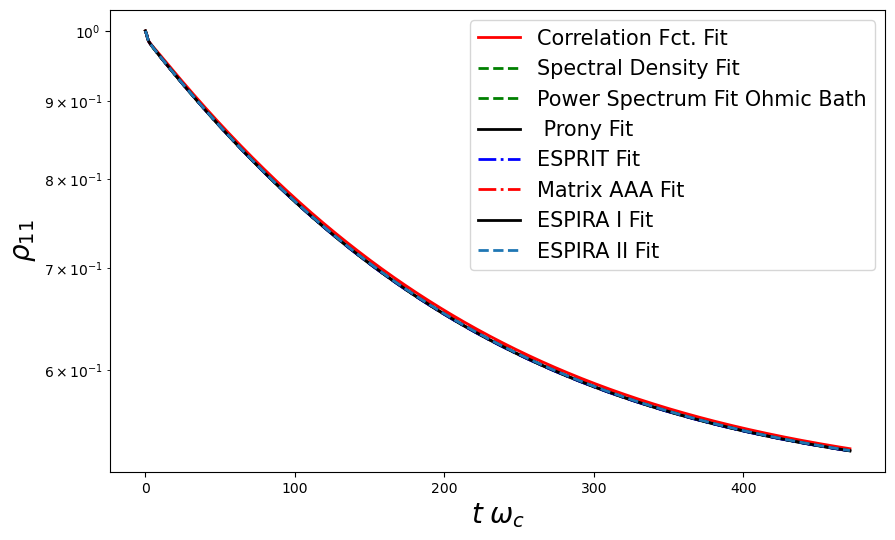

In [38]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

plot_result_expectations([
    (results_ohmic_corr_fit, P11p, "r", "Correlation Fct. Fit"),
    (results_ohmic_sd_fit, P11p, "g--", "Spectral Density Fit"),
    (results_ohmic_ps_fit, P11p, "g--", "Power Spectrum Fit Ohmic Bath"),
    (results_ohmic_prony_fit, P11p, "k", " Prony Fit"),
    (results_ohmic_es_fit, P11p, "b-.", "ESPRIT Fit"),
    (results_ohmic_aaa_fit, P11p, "r-.", "Matrix AAA Fit"),
    (results_ohmic_espira_fit, P11p, "k", "ESPIRA I Fit"),
    (results_ohmic_espira2_fit, P11p, "--", "ESPIRA II Fit"),
], axes=axes)

axes.set_ylabel(r"$\rho_{11}$", fontsize=20)
axes.set_xlabel(r"$t\;\omega_c$", fontsize=20)
axes.legend(loc=0, fontsize=15)
axes.set_yscale("log")

## About

In [39]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [40]:
assert np.allclose(
    expect(P11p, results_spectral_fit_pk[2].states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_ohmic_aaa_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_ohmic_prony_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)

assert np.allclose(
    expect(P11p, results_ohmic_es_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_ohmic_espira_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_ohmic_espira2_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)